In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
project_path=os.chdir('/content/drive/My Drive/Song data/')

#IMPORT LIBRARIES

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import KFold
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.layers.embeddings import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Bidirectional
from contextlib import redirect_stdout
with redirect_stdout(open(os.devnull, "w")):             ### Silence download progressing by re-directing to stdout
   nltk.download('stopwords')
   nltk.download('punkt')
   nltk.download('averaged_perceptron_tagger')
   nltk.download('wordnet')
   from nltk.corpus import stopwords


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


### Importing data

In [ ]:
def importing(filename): 
  path = filename + ".txt"
  
  a_file = open(path, "r",  encoding='windows-1252')
  words = []
  for line in a_file:
      stripped_line = line.strip()
      line_list = stripped_line
      words.append(line_list)
  a_file.close()
  DF = pd.DataFrame()
  DF[filename] = words
  return DF


# PREPROCESSING

## REMOVING STOPWORDS

In [ ]:
stop = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

In [ ]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

## LEMMATIZE

In [ ]:
#lemmatization 
def lemmatize_sentence(sentence):

    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    
    #tuple of (token, wordnet_tag)

    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

## REMOVING BLANK LINES

In [ ]:
def removing_lines(df):
  col = df.columns[0]
  df.dropna(inplace = True)
  df.drop([], inplace = True)
  df = df[~df[col].str.len().eq(0)]

  return df

## FINAL PREPROCESSING

In [ ]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " "  
    
    # traverse in the string   
    for ele in s:  
        
        str1 += ele   
        str1+=' '

    
    # return string   
    return str1  

In [ ]:
# function to identify & remove unwanted characters from text in "Combined Description"

def preprocess(data):
    
    temp1 =[]
    col = data.columns[0]
    for sentence in data[col]:
        sentence = sentence.lower() #lower case
        cleanr = re.compile('<.*?>')
        # sentence = re.sub(cleanr, ' ', sentence)        #removing HTML tags
        # sentence = re.sub(r'\S+@\S+', 'EmailId', sentence)#removing mail ids
        # sentence = re.sub(r'\S+@\S+', 'https', sentence)#removing https
        # sentence = re.sub(r'\S+@\S+', 'http', sentence)#removing http
        # sentence = re.sub(r'\'', '', sentence, re.I|re.A)
        # sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence)
        # sentence = sentence.lower()
        # sentence = re.sub(r'com ', ' ', sentence, re.I|re.A)
        # sentence = re.sub(r'Subject: ', ' ', sentence, re.I|re.A)
        # sentence = re.sub(r'\[cid:(.*)]', ' ', sentence, re.I|re.A)
        # sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)
        # sentence = re.sub(r'The information(.*)infection', ' ', sentence, re.I|re.A)  # footer
        # sentence = re.sub(r'Endava Limited is a company(.*)or omissions', ' ', sentence,  re.I|re.A)  # footer
        # sentence = re.sub(r'The information in this email is confidential and may be legally(.*)interference if you are not the intended recipient', ' ', sentence, re.I|re.A)  # footer
        # sentence = re.sub(r'select the following link to view the disclaimer in an alternate language.', ' ', sentence, re.I|re.A)  # disclaimer footer

        sentence = re.sub(r'[^\w\s]', '', sentence)  # will remove all punctuations
        sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)  # will remove all digits
        sentence = re.sub(r'aint' , '' , sentence)  
        sentence = re.sub("[\(\[].*?[\)\]]", "", sentence)  # Will remoce all brackets

        l_sentence = lemmatize_sentence(sentence)

        words = [word for word in l_sentence.split() if word not in stopwords.words('english')]  # stopword removal
        temp1.append(words)
        
    temp = []
    for sentence in temp1:
      temp.append(listToString(sentence))
    data[col] = temp
    return data
    #print ("Sentence = ",sentence)

# WORD FREQUENCY

In [ ]:
def freq_words(x, terms = 30): 
    all_words = []
    #all_words.append([text for text in x])
    all_words = ' '.join([text for text in x]) 
    #[i.split() for i in all_words]
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
    return d
# print 100 most frequent words

# WORDCLOUD

In [ ]:
# Python program to generate WordCloud 
def cloud(data):
      
    comment_words = '' 
    stopwords = set(STOPWORDS) 
      
    # iterate through the csv file 
    for val in data: 
          
        # typecaste each val to string 
        val = str(val) 
      
        # split the value 
        tokens = val.split() 
          
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
          
        comment_words += " ".join(tokens)+" "
      
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 
      
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
      
    plt.show() 

# BI GRAMS

In [ ]:
def bi_gram(data):
  word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
  sparse_matrix = word_vectorizer.fit_transform(data)
  frequencies = sum(sparse_matrix).toarray()[0]
  bi_grams_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
  print(bi_grams_df.sort_values(by = "frequency",ascending=False).head(5))


# TOKENIZE

In [ ]:
def get_all_words(df):
  col = df.columns[0]
  all_words = []
  for sentence in df[col]:
    sentence = sentence.split(' ')
    for i in sentence:
      if (i not in all_words):
        all_words.append(i)
  
  
  
  
  return all_words

In [ ]:
def get_all_wordstest(df):
  col = df.columns[0]
  all_words = []
  for sentence in df[col]:
    sentence = sentence.split(' ')
    for i in sentence:
      if (i not in all_words):
        all_words.append(i)
  
  
  
  
  return all_words

In [ ]:
# def token(df):
#   col = df.columns[0]
#   vocab_size = len(set(all_words))
#   tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
#   tokenizer.fit_on_texts(df[col])
#   X = tokenizer.texts_to_sequences(df[col])
#   X = pad_sequences(X, maxlen = 15)
#   y = np.asarray(df[col])

#   print("Vocabulary Size:", len(X))
#   print(X[1])
#   print("Sentence Size: ", len(y))
#   print(y[1])
#   return X

In [ ]:
# def tokentest(df):
#   col = df.columns[0]
#   vocab_size = len(set(all_words))
#   tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
#   tokenizer.fit_on_texts(df[col])
#   X = tokenizer.texts_to_sequences(df[col])
#   X = pad_sequences(X, maxlen = 15)
#   y = np.asarray(df[col])

  
#   return X

In [ ]:
def labelencoding(df):
  col = df.columns[1]
  encoder = preprocessing.LabelEncoder()
  Y = encoder.fit_transform(df[col])
  labelclasses = [0,1,2]
  actual = encoder.inverse_transform(labelclasses)
  print('The labels or each class are as follows:')
  for i in labelclasses:
    print(labelclasses[i], actual[i])
  return Y
 

# Count Vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def count_vectorizer(df):

  col = df.columns[0]
  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(df[col])
  return (X.toarray())

#TFIDF VECTORIZER

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(df):
  col = df.columns[0]
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(df[col]).toarray()
  #print(vectorizer.get_feature_names())
  return X

#TRAIN DATA PIPELINE

## IMPORTING PIPELINE

In [ ]:
drugs = importing('drugs')
miso = importing('misogyny')
violence = importing('violence')

In [ ]:
drugs.head()

,drugs
0,I drink I smoke
1,And who the fuck care smoking on this kush til...
2,I drink I smoke
3,"Pot, pot gimme some pot"
4,"High, high I wanna get high"


In [ ]:
miso.head()

,misogyny
0,Turn around bitch I got a use for you
1,Annie's twelve years old in two more she'll be...
2,Is the seven horny brothers and a drunk-ass dad
3,My psychic told me she'll have a ass like Serena
4,"If you fuckin' with this girl, then you better..."


In [ ]:
violence.head()

,violence
0,"You have a fight , One of you tries to grab a ..."
1,He accidentally gets his Adam's apple sliced.
2,panics And he gets his throat cut So now they ...
3,you slash your own throat So now it's double h...
4,your head cut off They'll find you with your b...


##MERGE

In [ ]:
df = pd.DataFrame()
df['text'] = miso['misogyny']
df['labels'] = 'misogyny'

df2 = pd.DataFrame()
df2['text'] = drugs['drugs']
df2['labels'] = 'drugs'

df = df.append(df2 , ignore_index=True)


df3 = pd.DataFrame()
df3['text'] = violence['violence']
df3['labels'] = 'violence'
df = df.append(df3 , ignore_index=True)


##PREPROCESSING PIPELINE

In [ ]:
df = removing_lines(df)
df = preprocess(df)


drugs = preprocess(drugs)
miso = preprocess(miso)
violence = preprocess(violence)

In [ ]:
df.head()

,text,labels
0,turn around bitch get use,misogyny
1,annies twelve year old two shell whore,misogyny
2,seven horny brother drunkass dad,misogyny
3,psychic tell shell like serena,misogyny
4,fuckin girl better pay,misogyny


In [ ]:
# miso = miso[0:99]
# violence = violence[0:99]

In [ ]:
print(miso.shape)
print(violence.shape)
print(drugs.shape)

(224, 1)
(201, 1)
(212, 1)


In [ ]:
all_words_miso = get_all_words(miso)
all_words_violence = get_all_words(violence)
all_words_drugs = get_all_words(drugs)

In [ ]:
worddf = pd.DataFrame()
worddf['text'] = all_words_miso
worddf['labels'] = 'misogyny'

df2 = pd.DataFrame()
df2['text'] = all_words_drugs
df2['labels'] = 'drugs'

worddf = worddf.append(df2 , ignore_index=True)


df3 = pd.DataFrame()
df3['text'] = all_words_violence
df3['labels'] = 'violence'
worddf = worddf.append(df3 , ignore_index=True)
worddf = removing_lines(worddf)
worddf = preprocess(worddf)



In [ ]:
print(df.head())

                                       text    labels
0                turn around bitch get use   misogyny
1   annies twelve year old two shell whore   misogyny
2         seven horny brother drunkass dad   misogyny
3           psychic tell shell like serena   misogyny
4                   fuckin girl better pay   misogyny


## VISUALIZATIONS PIPELINE

In [ ]:
bi_gram(miso['misogyny'])
bi_gram(drugs['drugs'])
bi_gram(violence['violence'])


            frequency
bitch shit          6
fuck bitch          5
say dick            4
bitch get           4
pussy like          3
            frequency
get high           14
get ta              8
ganja burn          6
im stoner           4
little bit          4
             frequency
get ta               3
dead body            3
body hit             2
gon na               2
fuck around          2


In [ ]:
all_words = get_all_words(df)

In [ ]:
len(all_words)

1021

#SWARAD MODELS

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#vec = tfidf(df)
vec = count_vectorizer(df)
Y = labelencoding(df)

rf = RandomForestClassifier()
param = {
    'n_estimators' : [10,150,300],
    'max_depth' : [30,60,90,None] ,
}
gs = GridSearchCV(rf , param , cv=3)
gs_fit = gs.fit(vec , Y)


The labels or each class are as follows:
0 drugs
1 misogyny
2 violence


In [ ]:
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score' , ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,0.351304,0.004304,0.019359,0.000313,60,150,"{'max_depth': 60, 'n_estimators': 150}",0.819512,0.726829,0.759804,0.768715,0.038359,1
8,0.741019,0.007576,0.041474,0.000887,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.814634,0.731707,0.759804,0.768715,0.034436,1
10,0.373609,0.004813,0.021615,0.000398,None,150,"{'max_depth': None, 'n_estimators': 150}",0.819512,0.721951,0.759804,0.767089,0.040161,3
5,0.698301,0.007974,0.039755,0.003180,60,300,"{'max_depth': 60, 'n_estimators': 300}",0.814634,0.726829,0.745098,0.762187,0.037828,4
2,0.606908,0.012574,0.037045,0.002854,30,300,"{'max_depth': 30, 'n_estimators': 300}",0.800000,0.707317,0.759804,0.755707,0.037948,5


# Naive Bayes Theorem

##### Multinomial NB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice)

In [ ]:
from sklearn.naive_bayes import MultinomialNB 
mnb = MultinomialNB()

col = df.columns[0]
vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(df[col]).toarray()
# print(vectorizer.get_feature_names())

x_test = importing('test')
x_test = removing_lines(x_test)
x_test = preprocess(x_test)
print(x_test)

col = x_test.columns[0]
x_test = vectorizer.transform(x_test[col]).toarray()
x_test[1]

In [ ]:
# print(Y_pred.shape)
m = [1]*15
v = [2]*13
d = [0]*19
Y_test = []
Y_test = m + v + d
print(len(Y_test))
print(x_test.shape)

mnb.fit(x_train, Y)   # Fitting the data

In [ ]:
Y_pred = mnb.predict(x_test)    # Predicting 

In [ ]:
length = len(Y_test)
count = 0 
for x in range(len(Y_test)):
  if Y_pred[x] == Y_test[x]:
    count += 1
print("Accuracy: {} %".format(count/length * 100))

In [ ]:
print(Y_pred)
print(Y_test)

# SVM

In [ ]:
Svm = svm.SVC(C=1.0 , kernel='linear', degree=3, gamma='auto')
Svm.fit(x_train ,Y)

Y_pred = Svm.predict(x_test)
length = len(Y_test)
count = 0

for x in range(len(Y_test)):
  if Y_pred[x] == Y_test[x]:
    count += 1
print("Accuracy: {} %".format(count/length * 100))

Accuracy: 79.3103448275862 %


# MNB using TFIDF Vector

In [ ]:
vec = tfidf(df)

mnb = MultinomialNB()
X_train, X_test, Y_train, Y_test = train_test_split(vec, Y , test_size = 0.30)

mnb.fit(X_train, Y_train)

Y_pred = mnb.predict(X_test)
print(Y_pred)
print(Y_test)

length = len(Y_test)

count = 0 
for x in range(len(Y_test)):
  if Y_pred[x] == Y_test[x]:
    count += 1
print("Accuracy: {} %".format(count/length * 100))

[0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 2 0 0 2 1 0 0 0 0 2 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
[0 0 0 2 0 1 2 2 0 1 2 0 0 1 0 1 1 1 0 0 1 1 1 0 0 2 0 0 2 2 0 1 1 2 1 2 0
 0 2 0 2 0 0 2 0 2 2 2 0 2 0 2 2 0 2 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 2 2 0 0 2 2 2 0 0 0 2 2 1 0 1 0 0 0 0 0 1]
Accuracy: 65.26315789473685 %


# Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB(binarize=0.0)

bnb.fit(X_train,Y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
Y_pred = bnb.predict(X_test)
count = 0 
for x in range(len(Y_test)):
  if Y_pred[x] == Y_test[x]:
    count += 1
print("Accuracy: {} %".format(count/length * 100))

Accuracy: 56.84210526315789 %


In [ ]:
print(Y_pred)
print(Y_test)

[0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0]
[2 2 0 2 2 0 0 2 2 0 0 1 1 1 0 0 2 1 0 0 2 1 0 1 1 0 0 2 0 0 1 1 0 2 0 0 0
 0 0 1 2 2 2 0 1 1 2 1 2 0 2 1 1 1 2 2 0 0 2 0 2 0 0 1 0 1 0 2 0 0 0 1 0 0
 2 1 2 2 2 2 2 1 1 0 1 0 2]


#Glove

In [ ]:
from numpy import zeros
embeddings_index = dict()
f = open('./glove.6B.100d.txt')

for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


In [ ]:
max_features = 700
tokenizer= Tokenizer(num_words= max_features)
tokenizer.fit_on_texts(df["text"])

vocab_size = len(get_all_words(df))
embedding_matrix = zeros((vocab_size+1, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

['', 'turn', 'around', 'bitch', 'get', 'use', 'besides', 'nothin', 'good', 'annies', 'twelve', 'year', 'old', 'two', 'shell', 'whore', 'im', 'staring', 'tit', 'wrong', 'way', 'strong', 'man', 'take', 'maid', 'need', 'keep', 'house', 'clean', 'fix', 'meal', 'go', 'away', 'someone', 'sit', 'move', 'ill', 'beat', 'shit', 'quit', 'cry', 'always', 'make', 'shout', 'tryna', 'fuck', 'first', 'night', 'different', 'page', 'swappin', 'ho', 'put', 'molly', 'champagne', 'even', 'know', 'home', 'enjoy', 'bag', 'play', 'save', 'phone', 'big', 'booty', 'hoe', 'trick', 'suckin', 'dick', 'buck', 'try', 'domesticate', 'ya', 'girl', 'little', 'bad', 'side', 'pull', 'sayin', 'gold', 'digger', 'messin', 'broke', 'niggas', 'tuesday', 'whatd', 'screw', 'dre', 'fake', 'lie', 'slut', 'never', 'tell', 'id', 'third', 'person', 'today', 'think', 'wouldnt', 'lot', 'easy', 'drop', 'dead', 'cause', 'drive', 'drink', 'back', 'whole', 'new', 'hatred', 'blonde', 'bias', 'hate', 'want', 'die', 'rather', 'leave', 'ditch

In [ ]:
embedding_matrix[200]

array([-0.11599   ,  0.24951001,  0.12368   ,  0.22826999, -0.98004001,
        0.90442002, -0.066431  ,  1.00759995, -0.51786   , -0.89721   ,
        0.06033   ,  0.45635   , -0.12329   ,  0.66055   ,  0.80738997,
       -0.22172   , -0.95432001,  0.11728   , -0.17465   , -0.32144001,
       -0.039212  , -0.14715999,  0.0085009 , -0.24536   , -0.11316   ,
        0.34656999, -0.19769   , -0.93313003,  0.40368   ,  0.45205   ,
       -0.21028   , -0.12304   , -0.34011999,  0.50079   , -0.60297   ,
        0.49643999, -0.27208   ,  0.58858001,  0.85881001, -0.33818999,
       -0.32652   ,  0.29934999, -0.49107   , -0.39021999, -0.25044   ,
       -0.29198   , -0.57297999,  0.42765   , -0.19709   , -1.02530003,
       -0.34852001, -0.77165002, -0.099004  ,  0.58822   ,  1.05879998,
       -1.46949995,  0.53688002,  0.29931   ,  0.82280999,  0.37577   ,
        0.27201   ,  1.13639998, -0.20126   , -0.82683003,  0.31854999,
        0.91860002,  0.66797   , -1.03639996,  0.39477   , -0.29

# LSTM MODEL

In [ ]:
len(set(all_words))

601

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'])

X = tokenizer.texts_to_sequences(df["text"])
X = pad_sequences(X, maxlen = 15)
y = np.asarray(df['labels'])

print("Number of Samples:", len(X))

print("Number of Labels: ", len(y))

Number of Samples: 288
Number of Labels:  288


In [ ]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

Y = encoder.fit_transform(df["labels"])

In [ ]:
labelclasses = [0,1,2]
actual = encoder.inverse_transform(labelclasses)
print('The labels or each class are as follows:')
for i in labelclasses:
  print(labelclasses[i], actual[i])

The labels or each class are as follows:
0 drugs
1 misogyny
2 violence


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30)

In [ ]:
vocab_size

601

In [ ]:
embed_dim = 128
lstm_out = 196
max_length = 15

model = Sequential()
model.add(Embedding(vocab_size+1, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

NameError: ignored

In [ ]:
model.compile?

#FIT DATA ON MODEL

In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), shuffle = True,  epochs = 70, batch_size= 50, verbose = 2)

Epoch 1/70
5/5 - 3s - loss: 1.0803 - accuracy: 0.4026 - val_loss: 1.0111 - val_accuracy: 0.5657
Epoch 2/70
5/5 - 0s - loss: 0.9760 - accuracy: 0.5584 - val_loss: 0.9180 - val_accuracy: 0.6465
Epoch 3/70
5/5 - 0s - loss: 0.8739 - accuracy: 0.6667 - val_loss: 0.8257 - val_accuracy: 0.6869
Epoch 4/70
5/5 - 0s - loss: 0.8197 - accuracy: 0.6970 - val_loss: 0.7337 - val_accuracy: 0.7071
Epoch 5/70
5/5 - 0s - loss: 0.7311 - accuracy: 0.7662 - val_loss: 0.6753 - val_accuracy: 0.6970
Epoch 6/70
5/5 - 0s - loss: 0.6831 - accuracy: 0.7316 - val_loss: 0.6588 - val_accuracy: 0.7273
Epoch 7/70
5/5 - 0s - loss: 0.6465 - accuracy: 0.7359 - val_loss: 0.6076 - val_accuracy: 0.7374
Epoch 8/70
5/5 - 0s - loss: 0.6070 - accuracy: 0.7403 - val_loss: 0.5932 - val_accuracy: 0.7374
Epoch 9/70
5/5 - 0s - loss: 0.6115 - accuracy: 0.7229 - val_loss: 0.5707 - val_accuracy: 0.7374
Epoch 10/70
5/5 - 0s - loss: 0.5552 - accuracy: 0.7619 - val_loss: 0.5529 - val_accuracy: 0.7677
Epoch 11/70
5/5 - 0s - loss: 0.5602 - a

# MODEL EVALUATION

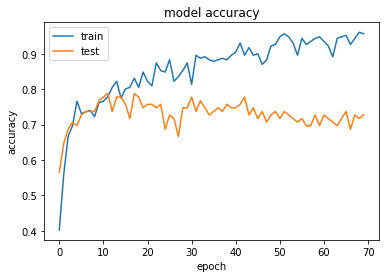

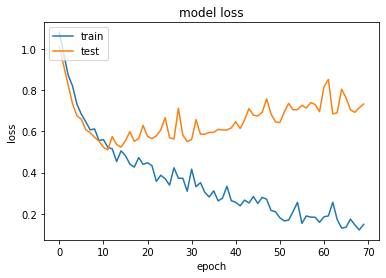

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# print(metrics.classification_report (Y_test, np.argmax(Y_pred, axis = 1),zero_division=1,target_names=np.unique(encoder.inverse_transform(Y_test))))

In [ ]:
Y_pred = model.predict(X_test, verbose=0)
#Y_pred

In [ ]:
predictions = []
for i in range (len(Y_pred)):
  for j in range (3):
      if (Y_pred[i][j] == Y_pred[i].max()):
        predictions.append(j)
predictions = np.array(predictions)

In [ ]:
print(Y_test)
print(predictions)

[1 1 2 1 1 2 1 2 0 2 0 2 2 1 0 2 1 0 0 2 0 2 0 0 2 2 1 2 2 0 2 1 1 0 1 1 2
 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 2 1 1 0 2 0 1 1 2 1 2 0 0 1 0 1 1 1 0 0 0 0
 1 1 1 2 1 2 2 1 0 0 0 0 1 0 0 2 0 2 0 0 1 2 1 1 2]
[2 1 2 1 1 2 2 0 0 2 2 2 2 1 0 2 1 1 0 2 1 1 0 0 1 2 1 2 2 0 2 0 2 1 0 1 2
 2 1 2 2 2 1 2 0 0 0 0 0 0 0 2 1 2 1 0 1 0 1 0 2 1 1 0 1 1 0 1 2 0 0 0 0 0
 1 1 1 2 1 2 1 1 0 0 0 0 0 0 0 2 0 2 0 0 1 2 1 0 2]


In [ ]:
length = len(Y_test)
count = 0
for x in range(length):
  if predictions[x] == Y_test[x]:
    count += 1
print("Accuracy: {} %".format(count/length * 100))

Accuracy: 72.72727272727273 %


In [ ]:
thresholds = []
flag = 0
for i in range (len(Y_pred)):
  for j in range (3):
      if (Y_pred[i][j] >= 0.7):
        thresholds.append(j)
        flag = 1
      
  if (flag==0):
    thresholds.append(9)
  flag = 0
thresholds = np.array(thresholds)

In [ ]:
print(Y_test)
print(thresholds)

[1 1 2 1 1 2 1 2 0 2 0 2 2 1 0 2 1 0 0 2 0 2 0 0 2 2 1 2 2 0 2 1 1 0 1 1 2
 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 2 1 1 0 2 0 1 1 2 1 2 0 0 1 0 1 1 1 0 0 0 0
 1 1 1 2 1 2 2 1 0 0 0 0 1 0 0 2 0 2 0 0 1 2 1 1 2]
[2 1 2 1 1 2 9 9 9 2 2 2 2 1 0 2 9 1 0 2 1 1 0 0 1 9 9 2 2 0 2 0 2 1 9 1 2
 2 1 9 9 2 1 2 9 0 0 0 0 0 0 2 1 9 1 9 1 0 1 9 2 9 9 0 9 1 0 1 9 9 0 0 0 0
 1 1 1 2 1 2 1 1 0 0 0 0 9 0 0 2 0 9 0 0 1 9 1 0 2]


#LSTM NEW

In [ ]:
all_words = get_all_words(df)

NameError: ignored

In [ ]:
df.shape

(614, 2)

In [ ]:
df.head()

,text,labels
0,turn around bitch get use,misogyny
1,annies twelve year old two shell whore,misogyny
2,seven horny brother drunkass dad,misogyny
3,psychic tell shell like serena,misogyny
4,fuckin girl better pay,misogyny


In [ ]:
# vocab_size = len(set(all_words)) 
# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
# tokenizer.fit_on_texts(df['text'])

# train_inputs = tokenizer.texts_to_sequences(df['text'])

vocab_size = len(set(all_words))
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'])

X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen = 15)
y = np.asarray(df['text'])


In [ ]:
# X = tokenizer.texts_to_sequences(df['text'])
# X = pad_sequences(X, maxlen = 15)
# y = np.asarray(df['text'])

print("Number of Samples:", len(X))
print(X[8])
print("Number of Labels: ", len(y))
print(y[8])

Number of Samples: 614
[  0   0   0   0   0   0   0   0   0   0   0   0   2   6 384]
Number of Labels:  614
 bitch fuck tuesday 


In [ ]:
encoder = preprocessing.LabelEncoder()
Y = encoder.fit_transform(df['labels'])
labelclasses = [0,1,2]
actual = encoder.inverse_transform(labelclasses)
print('The labels or each class are as follows:')
for i in labelclasses:
  print(labelclasses[i], actual[i])

The labels or each class are as follows:
0 drugs
1 misogyny
2 violence


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(429, 15) (429,)
(185, 15) (185,)


In [ ]:
Embedding(len(set(all_words)) , 32, input_length=15)

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = 15))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 128)           130688    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 15, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 3)                 591       
Total params: 386,079
Trainable params: 386,079
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy',  verbose=1,
    save_best_only=True, mode='max', period=1)


In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size=batch_size, verbose = 2, callbacks=[checkpoint])

Epoch 1/20
14/14 - 6s - loss: 1.0977 - accuracy: 0.3473 - val_loss: 1.0854 - val_accuracy: 0.4324

Epoch 00001: val_accuracy improved from -inf to 0.43243, saving model to best_model2.hdf5
Epoch 2/20
14/14 - 1s - loss: 1.0630 - accuracy: 0.5361 - val_loss: 1.0525 - val_accuracy: 0.5568

Epoch 00002: val_accuracy improved from 0.43243 to 0.55676, saving model to best_model2.hdf5
Epoch 3/20
14/14 - 1s - loss: 0.9741 - accuracy: 0.7203 - val_loss: 0.9494 - val_accuracy: 0.6703

Epoch 00003: val_accuracy improved from 0.55676 to 0.67027, saving model to best_model2.hdf5
Epoch 4/20
14/14 - 1s - loss: 0.7599 - accuracy: 0.7949 - val_loss: 0.7181 - val_accuracy: 0.7459

Epoch 00004: val_accuracy improved from 0.67027 to 0.74595, saving model to best_model2.hdf5
Epoch 5/20
14/14 - 1s - loss: 0.4268 - accuracy: 0.8834 - val_loss: 0.5841 - val_accuracy: 0.8108

Epoch 00005: val_accuracy improved from 0.74595 to 0.81081, saving model to best_model2.hdf5
Epoch 6/20
14/14 - 1s - loss: 0.2446 - accu

In [ ]:
X.shape

(630, 15)

# Grid Search for LSTM

In [ ]:
GridSearchCV?

In [ ]:
# epochs = [30,50,100]
# learn_rate = [0.01 , 0.03 , 0.09]
# dropout_rate =[0.0, 0.1, 0.5, 0.9]

# param_grid = dict(epochs=epochs, learn_rate = learn_rate , dropout_rate = dropout_rate)
# grid = GridSearchCV(estimator=model , param_grid=param_grid , n_jobs=-1)
# grid_result = grid.fit(X_train , Y_train)

In [ ]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring=ftwo_scorer, cv=3)
grid_result = grid.fit(X_train, Y_train)

TypeError: ignored

#REDEFINE MODEL AND TOKENIZER

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(1021, embed_dim,input_length = 15))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

model.load_weights("Working.hdf5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 128)           130688    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 15, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 3)                 591       
Total params: 386,079
Trainable params: 386,079
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
vocab_size = len(set(all_words))
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'])

# MASS TESTING FUNCTIONS

In [ ]:
def importfortest(directory , filename): 
  path = directory + filename
  
  a_file = open(path, "r", encoding='utf8')
  words = []
  for line in a_file:
      stripped_line = line.strip()
      line_list = stripped_line
      words.append(line_list)
  a_file.close()
  DF = pd.DataFrame()
  
  DF['text'] = words
  return DF


In [ ]:
def findthresholds(Y_pred):
  thresholds = []
  flag = 0
  for i in range (len(Y_pred)):
    for j in range (3):
        if (Y_pred[i][j] >= 0.8):
          thresholds.append(j)
          flag = 1
        
    if (flag==0):
      thresholds.append(9)
    flag = 0
  thresholds = np.array(thresholds)
  return thresholds

In [ ]:
# def findthresholds(Y_pred):

#   Y_new = []
#   flag = 0      #flag signifies whether 0.8+ probability is present or not

#   for i in range(Y_pred.shape[0]):

#     for j in range(Y_pred.shape[1]):

#       if Y_pred[i][j] >= 0.8:
#         flag = 1
    
#     if flag:
#       Y_new.append(np.argmax(Y_pred[i]))
#     else:
#       Y_new.append(9)
    
#     flag = 0

#   # print(Y_new)
#   # print(Y_pred)

#   return Y_new


In [ ]:
def findpercentages(thresholds):
    drugs = 0
    miso = 0
    violence = 0
    count9 = 0
    for i in thresholds:
      if i == 0:
        drugs+=1
      elif i == 1: 
        miso+=1
      elif i == 2:
        violence+=1
      elif i == 9:
        count9+=1
    total = drugs + miso + violence + count9
    return (drugs/total)*100, (miso/total)*100, (violence/total)*100, (count9/total)*100



```
# This is formatted as code
```

# OPEN THIS And run for new excel sheet

In [ ]:
allrecords = pd.DataFrame()

In [ ]:
#@title 
Year = 2013 #@param {type:"integer"}
Enter_Again = "2013" #@param {type:"string"}


#PIPELINE (MASS TESTING)

In [ ]:
#FOR ACCEPTED AND WORDWISE TESTING
import os

directory = Enter_Again + "/"
all_words = get_all_words(df)
records = pd.DataFrame()
drugpercentage = []
violencepercentage = []
misopercentage = []
peacepercentage = []
year = []
song = []
label = []
miso_count = 0
drug_count = 0
vio_count = 0
peace_count = 0
year_wise = pd.DataFrame()

for filename in os.listdir(directory):
    
    
    if filename.endswith(".txt"): 
          testdf = importfortest(directory, filename)
          testdf = removing_lines(testdf)
          testdf = preprocess(testdf)
       
          test_all_words = get_all_wordstest(testdf)
          all_words = get_all_words(df)

                    
          final_sen = []
          for sentence in testdf['text']:
            sentence = sentence.split(' ')
            sentence1 = ''
            for word in sentence:
        
              if word in all_words:
                sentence1 = sentence1 + ' ' + word
            
            final_sen.append(sentence1)

          X = tokenizer.texts_to_sequences(final_sen)
          X = pad_sequences(X, maxlen = 15)
          
          Y_pred = model.predict(X, verbose=0)
          thresholds = findthresholds(Y_pred)
          drugs, miso, violence, peace = findpercentages(thresholds)
          drugpercentage.append(drugs)
          misopercentage.append(miso)
          violencepercentage.append(violence)
          peacepercentage.append(peace)
          year.append(Year)
          song.append(filename)


          if peace > 60:

              if miso>20:
                label.append('Misogyny')
                miso_count += 1

              elif drugs>20:
                label.append('Drugs')
                drug_count += 1

              elif violence>20:
                label.append('Violence')
                vio_count += 1
                
              else:
                label.append('Peace')
                peace_count += 1

          else:
              if miso>drugs and miso>violence:
                label.append('Misogyny')
                miso_count += 1
          
              elif drugs>miso and drugs>violence:
                label.append('Drugs')
                drug_count += 1

              else:
                label.append('Violence')
                vio_count += 1      

          continue
    else:
          continue


print("Miso:",miso_count)
print("Drugs:",drug_count)
print("Violence:",vio_count)


# except:
#   continue
records['Year'] = year
records['song'] = song
records['drug%'] = drugpercentage
records['misogyny%'] = misopercentage
records['violence%'] = violencepercentage
records['peace%'] = peacepercentage
records['Label'] = label
allrecords = allrecords.append(records)

Miso: 46
Drugs: 20
Violence: 18


In [ ]:
# import os
# #FOR NORMAL SENTENCE WISE WITH ALL WORDS
# directory = Enter_Again + "/"
# all_words = get_all_words(df)
# records = pd.DataFrame()
# drugpercentage = []
# violencepercentage = []
# misopercentage = []
# peacepercentage = []
# year = []
# song = []

    
    
#     if filename.endswith(".txt"): 
#           testdf = importfortest(directory, filename)
#           testdf = removing_lines(testdf)
#           testdf = preprocess(testdf)
#           test_all_words = get_all_wordstest(testdf)
          
#           X = tokenizer.texts_to_sequences(testdf['text'])
#           X = pad_sequences(X, maxlen = 15)
#           vocab_size = len(set(test_all_words)) 
#           Y_pred = model.predict(X, verbose=0)
#           thresholds = findthresholds(Y_pred)
#           drugs, miso, violence, peace = findpercentages(thresholds)
#           drugpercentage.append(drugs)
#           misopercentage.append(miso)
#           violencepercentage.append(violence)
#           peacepercentage.append(peace)
#           year.append(Year)
#           song.append(filename)
          
          
#           continue
#     else:
#           continue
# # except:
# #   continue
# records['Year'] = year
# records['song'] = song
# records['drug%'] = drugpercentage
# records['misogyny%'] = misopercentage
# records['violence%'] = violencepercentage
# records['peace%'] = peacepercentage
# allrecords = allrecords.append(records)

#MASS TEST OUTPUT

In [ ]:
allrecords.head(50)

,Year,song,drug%,misogyny%,violence%,peace%
0,2011,My Last.txt,11.340206,13.402062,22.680412,52.577320
1,2011,The Greatest Story Never told.txt,25.263158,11.578947,11.578947,51.578947
2,2011,Lord Knows.txt,14.606742,28.089888,15.730337,41.573034
3,2011,Freaks and Geeks.txt,12.307692,32.307692,15.384615,40.000000
4,2011,Rigamortus.txt,18.181818,9.090909,25.974026,46.753247
5,2011,Cocoa Butter.txt,28.571429,9.821429,14.285714,47.321429
6,2011,Late for the sky.txt,5.714286,31.428571,8.571429,54.285714
7,2011,Fuck Your Ethnicity.txt,17.910448,17.910448,11.940299,52.238806
8,2011,Lighters.txt,26.262626,14.141414,14.141414,45.454545
9,2011,Dance in the reign.txt,11.111111,23.809524,12.698413,52.380952


In [ ]:
allrecords.to_excel(r'2015_final.xlsx', index = False)

#SINGLE SONG TESTING

In [ ]:
testdf = importing('testsong')
testdf = removing_lines(testdf)
testdf = preprocess(testdf)

In [ ]:
test_all_words = get_all_words(testdf)

In [ ]:
all_words = get_all_words(df)

In [ ]:
# accepted = []
# rejected = []
# for word in test_all_words:
#   if (word in all_words):
#     accepted.append(word)
#   else:
#     rejected.append(word)

In [ ]:

final_sen = []
for sentence in testdf['testsong']:

  sentence = sentence.split(' ')

  sentence1 = ''
  for word in sentence:
    
    count_all = len(sentence)
    if word in all_words:
      sentence1 = sentence1 + ' ' + word
      sentence1= re.sub('', '', sentence1)
  final_sen.append(sentence1)


final_sen
# final_sen = []
# for i in range(len(percentages)):
#   if percentages[i] >= 90:
#     final_sen.append(testdf['testsong'].iloc[i])

['  im ',
 '  wan na play ',
 '  tell wasnt shit thats murder ',
 '  wasnt find head cut ',
 '  dont let em run catch em ',
 '  grab arm grab arm let pull till em ',
 '  play pussy get fuck mean youre well dead ',
 '  wan na see head ',
 '  motherfucker cause im sick ',
 '  dead head leg mix ',
 '  night dead ',
 '  arm walk round givin nigga head ',
 '  didnt die would say get ',
 '  body find dead fuck ',
 '  play ',
 '  fuck killin ',
 '  gim barb ill start killin ',
 '  murder try slack ',
 '  little girl back ',
 '  name say im ',
 '  give gin might eat dog brain ',
 '  give motherfuckin pack ',
 '  ill damn dont bring dead nigga back ',
 '  murder contest know ill win ',
 '  cause every head knife ',
 '  im gettin hungry need ',
 '  feel like bag broke leg ',
 '  bustin neck brick ',
 '  half body half ',
 '  short nigga always ',
 '  figure way get fist ',
 '  get get light ',
 '  knife neck make spit ',
 '  ',
 '  inside chest find ',
 '  nerve try go ',
 '  gun fuck gon na yo 

In [ ]:
# all_words = get_all_words(df)

In [ ]:
# len(all_words)

In [ ]:
vocab_size = len(set(all_words))
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'])



In [ ]:


X = tokenizer.texts_to_sequences(final_sen)
X = pad_sequences(X, maxlen = 15)
y = np.asarray(final_sen)

print("Vocabulary Size:", len(X))
print(X[1])
print("Sentence Size: ", len(y))
print(y[1])

Vocabulary Size: 59
[  0   0   0   0   0   0   0   0   0   0   0   0  75  35 240]
Sentence Size:  59
  wan na play 


In [ ]:

# X = tokenizer.texts_to_sequences(testdf['testsong'])
# X = pad_sequences(X, maxlen = 15)
# y = np.asarray(testdf['testsong'])

# print("Vocabulary Size:", len(X))
# print(X[0])
# print("Sentence Size: ", len(y))
# print(y[0])

In [ ]:
testdf.head(10)

,testsong
0,hi im chuckie
1,wan na play
2,tell size wasnt shit thats murder niece
3,wasnt fault find head cut piece
4,dont let em run hurry catch em
5,grab arm grab arm let pull till stretch em
6,play pussy get fuck mean youre well dead
7,wan na see food fish child head
8,motherfucker weary cause im sick
9,dead head frog leg mmm cake mix


In [ ]:
# vocab_size = len(set(all_words)) 

In [ ]:
Y_pred = model.predict(X, verbose=0)
Y_pred


array([[6.3678968e-01, 7.1018495e-02, 2.9219186e-01],
       [7.3800129e-01, 4.4858716e-02, 2.1713994e-01],
       [5.9130888e-02, 8.3607894e-01, 1.0479021e-01],
       [2.6429580e-05, 2.9652263e-04, 9.9967706e-01],
       [9.9982566e-01, 2.4475599e-05, 1.4991936e-04],
       [4.9235598e-05, 3.1151585e-06, 9.9994767e-01],
       [6.6169709e-10, 1.0000000e+00, 5.1631799e-10],
       [9.7005826e-01, 5.3432384e-03, 2.4598410e-02],
       [1.5053094e-02, 2.5903974e-02, 9.5904285e-01],
       [2.3599941e-06, 4.7887629e-06, 9.9999285e-01],
       [1.1150653e-02, 3.4159757e-02, 9.5468956e-01],
       [1.0159753e-01, 4.8072562e-01, 4.1767690e-01],
       [6.5153622e-04, 9.9913615e-01, 2.1238181e-04],
       [2.6130879e-08, 3.4497020e-07, 9.9999964e-01],
       [4.4912571e-01, 1.3219510e-01, 4.1867921e-01],
       [2.6853385e-03, 7.9829335e-02, 9.1748536e-01],
       [8.8932200e-07, 7.2752300e-06, 9.9999189e-01],
       [1.4161292e-04, 4.0310177e-05, 9.9981815e-01],
       [1.6510470e-02, 9.805

In [ ]:
thresholds = []
flag = 0
for i in range (len(Y_pred)):
  for j in range (3):
      if (Y_pred[i][j] >= 0.8):
        thresholds.append(j)
        flag = 1
      
  if (flag==0):
    thresholds.append(9)
  flag = 0
thresholds = np.array(thresholds)

In [ ]:
thresholds

array([9, 9, 1, 2, 0, 2, 1, 0, 2, 2, 2, 9, 1, 2, 9, 2, 2, 2, 1, 1, 1, 2,
       2, 2, 2, 0, 9, 2, 2, 1, 1, 9, 2, 9, 1, 2, 2, 9, 2, 2, 9, 1, 2, 1,
       2, 1, 1, 9, 2, 0, 2, 9, 9, 1, 1, 9, 9, 1, 1])

The labels or each class are as follows:
0 drugs
1 misogyny
2 violence

In [ ]:
drugs = 0
miso = 0
violence = 0
count9 = 0
for i in thresholds:
  if i == 0:
    drugs+=1
  elif i == 1: 
    miso+=1
  elif i == 2:
    violence+=1
  elif i == 9:
    count9+=1
total = drugs + miso + violence + count9


#OUTPUT

In [ ]:
print("Misogyny count:" , (miso/total) * 100)
print("Drugs count:" , (drugs/total) * 100)
print("Violence count:" , (violence/total) * 100)
print("Peace count:" , (count9/total) * 100)

Misogyny count: 28.8135593220339
Drugs count: 6.779661016949152
Violence count: 40.67796610169492
Peace count: 23.728813559322035


In [ ]:
thresholds

array([9, 9, 1, 2, 1, 1, 0, 1, 2, 9, 1, 0, 1, 9, 1, 1, 2, 1, 2, 0, 2, 2,
       0, 0, 9, 1, 0, 2, 9, 1, 0, 0, 9, 1, 9, 1, 9, 1, 9, 1, 1, 0, 9, 9,
       1, 1, 1, 9, 0, 0, 9, 2, 2, 9, 2, 1, 1, 9, 9, 1, 1, 9, 1, 1, 0, 2,
       9, 1, 1, 1, 1, 0, 1, 9, 1, 9, 1, 9, 1, 9, 1, 1, 1])

In [ ]:

final_sen

['  say ',
 '  seven day ',
 '  pussy ',
 '  make game ',
 '  yeah yeah yeah yeah ',
 '  yeah fuck pussy ',
 '  bring pussy ',
 '  give get pussy ',
 '  beat nigga catch ',
 '  large hard ',
 '  put pussy right face ',
 '  nose like ',
 '  hop top wan na ',
 '  inside ',
 '  spit mouth look eye ',
 '  pussy wet come take dive ',
 '  tie like im ',
 '  let play ill ',
 '  want big ',
 '  right little ',
 '  make make scream ',
 '  public make ',
 '  dont cook dont clean ',
 '  let tell get ',
 '  side yeah ',
 '  jump let get inside yeah ',
 '  tell put never tell im bout ',
 '  ill run nigga run ',
 '  talk shit bite lip yeah ',
 '  car dick dick ',
 '  really never get ta fuck yeah ',
 '  make mind come ',
 '  get ',
 '  pussy ',
 '  buy phone ',
 '  pussy ',
 '  pay kiss ',
 '  pussy ',
 '  make wan na ',
 '  see pussy yeah yeah ',
 '  look need hard need ',
 '  need need weed smoker ',
 '  need ',
 '  hope ',
 '  get money thats im head ',
 '  pussy like ',
 '  get well im tryna wet

In [ ]:
thresholds

array([9, 9, 1, 2, 1, 1, 0, 1, 2, 9, 1, 0, 1, 9, 1, 1, 2, 1, 2, 0, 2, 2,
       0, 0, 9, 1, 0, 2, 9, 1, 0, 0, 9, 1, 9, 1, 9, 1, 9, 1, 1, 0, 9, 9,
       1, 1, 1, 9, 0, 0, 9, 2, 2, 9, 2, 1, 1, 9, 9, 1, 1, 9, 1, 1, 0, 2,
       9, 1, 1, 1, 1, 0, 1, 9, 1, 9, 1, 9, 1, 9, 1, 1, 1])

In [ ]:
Y_pred

array([[4.77454931e-01, 3.76256853e-01, 1.46288246e-01],
       [5.61021864e-01, 2.86449552e-01, 1.52528599e-01],
       [1.02571234e-01, 8.29579651e-01, 6.78490698e-02],
       [3.91292125e-02, 1.49151403e-02, 9.45955634e-01],
       [5.30967582e-03, 9.94690299e-01, 5.21858716e-08],
       [2.64399223e-05, 9.99967217e-01, 6.34679782e-06],
       [8.45281661e-01, 8.33726972e-02, 7.13456050e-02],
       [1.19371945e-03, 9.97604549e-01, 1.20171276e-03],
       [7.81995186e-04, 2.76007946e-03, 9.96457875e-01],
       [4.12372917e-01, 2.93798149e-01, 2.93828905e-01],
       [1.17641844e-06, 9.99997258e-01, 1.59208423e-06],
       [9.94317591e-01, 1.44741079e-03, 4.23507253e-03],
       [5.30533167e-03, 9.90847945e-01, 3.84680880e-03],
       [3.55566531e-01, 2.81155854e-01, 3.63277555e-01],
       [2.03507028e-07, 9.99999762e-01, 2.43289406e-08],
       [1.07125846e-08, 1.00000000e+00, 4.67896832e-11],
       [6.45089373e-02, 7.34429061e-02, 8.62048149e-01],
       [9.24916565e-02, 8.98798

#Predicting popular hip hop songs yearwise

In [ ]:
import pandas as pd

In [ ]:
siddf = pd.read_csv('songs.csv')

In [ ]:
len(siddf)

In [ ]:
siddf.iloc[3]['Name']

In [ ]:
import json
import requests
lyrics = []
try:
  artist = 'Taylor Swift'
  song = 'Delicate'
  url = 'https://api.lyrics.ovh/v1/' + artist + '/' + song

  response = requests.get(url)
  json_data = json.loads(response.content)
  lyrics = json_data['lyrics']
except:
  print('NOT FOUND')

In [ ]:
lyrics

In [ ]:
import pprint

# PIPELINE (FOR TESTING)

In [ ]:
testdf = pd.DataFrame()

In [ ]:
lyrics

In [ ]:
lyrics = lyrics.split('\n\n')

In [ ]:
lyrics

In [ ]:
testdf['text'] = lyrics


In [ ]:
testdf

In [ ]:
testdf = removing_lines(testdf)
testdf = preprocess(testdf)

In [ ]:
bi_gram(testdf['text'])

In [ ]:
e = freq_words(testdf['text'], 100)

In [ ]:
testdf = preprocess(testdf)

In [ ]:
testdf.shape

In [ ]:
all_words = get_all_words(testdf)
X = token(testdf)

# PREDICT NEW SONG

In [ ]:
Y_pred = model.predict(X, verbose=0)
Y_pred


In [ ]:
thresholds = []
flag = 0
for i in range (len(Y_pred)):
  for j in range (3):
      if (Y_pred[i][j] >= 0.7):
        thresholds.append(j)
        flag = 1
      
  if (flag==0):
    thresholds.append(9)
  flag = 0
thresholds = np.array(thresholds)

In [ ]:
thresholds

In [ ]:
# Needs to be changed
count0 = 0
count1 = 0
count2 = 0 
count9 = 0
for i in thresholds:
  if i == 1:
    count1+=1
  elif i == 0: 
    count0+=1
  elif i == 2:
    count2+=1
  elif i == 9:
    count9+=1
print("Drugs count:" , count0)
print("Misogyny count:" , count1)
print("Violence count:" , count2)
print("Peace count:" , count9)

#Logistic Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#SAVING THE MODEL

In [ ]:

model.save('saved_model/lstm') 

In [ ]:
#!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
#!ls saved_model/lstm

#USING K FOLD

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_reg = RandomForestRegressor()

In [ ]:
Y.shape

In [ ]:

from sklearn.model_selection import cross_val_score, cross_val_predict
cv_r2_scores_rf = cross_val_score(rf_reg, X, Y, cv=5,scoring='r2')

In [ ]:

kf = KFold(n_splits = 5, shuffle = True)

BAGGING

In [ ]:
from sklearn.ensemble import BaggingClassifier
bgcl = BaggingClassifier(n_estimators=100, max_samples=.50 , oob_score=True)

bgcl = bgcl.fit(X, Y)
print(bgcl.oob_score_)

BOOSTING

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier( n_estimators=50, random_state=1)
#abcl = AdaBoostClassifier(n_estimators=50)
abcl = abcl.fit(X_train, Y_train)

In [ ]:
test_pred = abcl.predict(X_test)
abcl.score(X_test , Y_test)

GRADIENT BOOSTING

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.09, max_depth=5)
gbcl = gbcl.fit(X_train, Y_train)

In [ ]:
test_pred = gbcl.predict(X_test)
gbcl.score(X_test , Y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfcl = RandomForestClassifier(n_estimators = 6)
rfcl = rfcl.fit(X_train, Y_train)

In [ ]:
test_pred = rfcl.predict(X_test)
rfcl.score(X_test , Y_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion = 'entropy' )

In [ ]:
dt_model.fit(X_train, Y_train)

In [ ]:
dt_model.score(X_test , Y_test)

In [ ]:
dt_model.score(X_train, Y_train) 

In [ ]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', class_weight={0:.5,1:.5}, max_depth = 3, min_samples_leaf=5 )
dt_model.fit(X_train, Y_train)


In [ ]:
dt_model.score(X_test , Y_test)

In [ ]:
dt_model.score(X_train, Y_train)

In [ ]:
gbcl = GradientBoostingClassifier(n_estimators = 50,learning_rate = 0.09, max_depth=5,algorithm = "SAMME.R")
gbcl = gbcl.fit(X_train, Y_train)

### TESTING FOR NEW SONG

In [ ]:
a_file = open("song.txt" , "r") 
print(a_file)

new = []

for line in a_file:

    stripped_line = line.strip()

    line_list = stripped_line

    new.append(line_list)

a_file.close()

DF_new= pd.DataFrame()
DF_new['new'] = new



#print(doroth_diags)


In [ ]:
DF_new

In [ ]:
from contextlib import redirect_stdout
with redirect_stdout(open(os.devnull, "w")):             ### Silence download progressing by re-directing to stdout
   nltk.download('stopwords')
   nltk.download('punkt')
   nltk.download('averaged_perceptron_tagger')
   nltk.download('wordnet')
   from nltk.corpus import stopwords

In [ ]:
stop = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

In [ ]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [ ]:
#lemmatization 
def lemmatize_sentence(sentence):

    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    
    #tuple of (token, wordnet_tag)

    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
# function to identify & remove unwanted characters from text in "Combined Description"
temp1 =[]
for sentence in DF_new['new']:
    sentence = sentence.lower() #lower case
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #removing HTML tags
    sentence = re.sub(r'\S+@\S+', 'EmailId', sentence)#removing mail ids
    sentence = re.sub(r'\S+@\S+', 'https', sentence)#removing https
    sentence = re.sub(r'\S+@\S+', 'http', sentence)#removing http
    sentence = re.sub(r'\'', '', sentence, re.I|re.A)
    sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
    sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'com ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'Subject: ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'\[cid:(.*)]', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)
    #sentence = re.sub(r'The information(.*)infection', ' ', sentence, re.I|re.A)  # footer
    #sentence = re.sub(r'Endava Limited is a company(.*)or omissions', ' ', sentence,  re.I|re.A)  # footer
    #sentence = re.sub(r'The information in this email is confidential and may be legally(.*)interference if you are not the intended recipient', ' ', sentence, re.I|re.A)  # footer
    #sentence = re.sub(r'select the following link to view the disclaimer in an alternate language.', ' ', sentence, re.I|re.A)  # disclaimer footer
    l_sentence = lemmatize_sentence(sentence)

    words = [word for word in l_sentence.split() if word not in stopwords.words('english')]
    temp1.append(words)

    #print ("Sentence = ",sentence)

In [ ]:
temp1

In [ ]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " "  
    
    # traverse in the string   
    for ele in s:  
        
        str1 += ele   
        str1+=' '

    
    # return string   
    return str1  
        
        
# Driver code     
for sentence in range (len(temp1)):
  DF_new['new'][sentence] = listToString(temp1[sentence])

In [ ]:
DF_new

In [ ]:
all_words = list()
for w in DF_new['new']:
    all_words.append(w)

In [ ]:
print('Size of vocabulary: {}'.format(len(set(all_words))))

In [ ]:
index_dict = dict()
count = 1
index_dict['<unk>'] = 0
for word in set(all_words):
    index_dict[word] = count
    count += 1

In [ ]:
vocab_size = (len(set(all_words)))  # There are 6655 words in total
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(DF_new['new'])

train_inputs = tokenizer.texts_to_sequences(DF_new['new'])
sns.distplot([len(l) for l in train_inputs])

In [ ]:
A = tokenizer.texts_to_sequences(DF_new['new'])
A = pad_sequences(A, maxlen = len(set(all_words)))
B = np.asarray(DF_new['new'])

print("Number of Samples:", len(A))
print(A[18])
print("Number of Labels: ", len(B))
print(B[18])

In [ ]:
Embedding((len(set(all_words))), 32, input_length= len(set(all_words)))

In [ ]:
# predict probabilities for test set
B_pred = model.predict(A, verbose=0)

In [ ]:
print(B_pred)

In [ ]:
DF_new.tail(10)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = 15))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())